<a href="https://colab.research.google.com/github/adnil8130/T5LittleGenQA/blob/main/T5%E7%94%9F%E6%88%90%E5%BC%8F%E9%97%AE%E7%AD%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 目标
训练一个生成式问答模型，base模型采用Google T5-Base("uer/t5-base-chinese-cluecorpussmall")

预训练模型地址：https://huggingface.co/uer/t5-base-chinese-cluecorpussmall

模型的评价指标采用BLEU-1，BLEU-2，BLEU-3，BLEU-4。

# 数据集
数据集：链接：https://pan.quark.cn/s/6d4a98cd65f2    

提取码：bzne

数据的格式如下：
```
{"context": "违规分为:一般违规扣分、严重违规扣分、出售假冒商品违规扣分,淘宝网每年12月31日24:00点会对符合条件的扣分做清零处理,详情如下:|温馨提醒:由于出售假冒商品24≤N<48分,当年的24分不清零,所以会存在第一年和第二年的不同计分情况。", "answer": "12月31日24:00", "question": "淘宝扣分什么时候清零", "id": 203}
```

# 1. 准备数据

In [147]:
# ! pip install transformers

In [148]:
import transformers
import numpy as np
import torch
print(transformers.__version__)
print(torch.__version__)
from torch.utils.data import Dataset, random_split
import json

4.49.0
2.5.1+cu124


In [149]:
max_context_len = 0
max_question_len = 0
max_answer_len = 0
context = ""
questiont = ""
answer = ""

context_len = []
question_len = []
answer_len = []

save_path_file = '.'
train_data_address = save_path_file + '/train.json'
dev_data_address = save_path_file + '/dev.json'

with open(train_data_address, 'rt', encoding='utf-8') as f:
  for idx, line in enumerate(f):
    sample = json.loads(line.strip())
    context_len.append(len(sample['context']))
    question_len.append(len(sample['question']))
    answer_len.append(len(sample['answer']))
    if len(sample["context"]) > max_context_len:
        max_context_len = len(sample["context"])
        context = sample["context"]
    if len(sample["question"]) > max_question_len:
        max_question_len = len(sample["question"])
        question = sample["question"]
    if len(sample["answer"]) > max_answer_len:
        max_answer_len = len(sample["answer"])
        answer = sample["answer"]

with open(dev_data_address, 'rt', encoding='utf-8') as f:
  for idx, line in enumerate(f):
    sample = json.loads(line.strip())
    context_len.append(len(sample['context']))
    question_len.append(len(sample['question']))
    answer_len.append(len(sample['answer']))
    if len(sample["context"]) > max_context_len:
        max_context_len = len(sample["context"])
        context = sample["context"]
    if len(sample["question"]) > max_question_len:
        max_question_len = len(sample["question"])
        question = sample["question"]
    if len(sample["answer"]) > max_answer_len:
        max_answer_len = len(sample["answer"])
        answer = sample["answer"]

print("最长context", max_context_len, context)
print("最长question", max_question_len, question)
print("最长answer", max_answer_len, answer)

最长context 1881 孩子几点睡觉最能长高个？现在很多家长已经意识到孩子的身高不完全是受父母遗传的因 素所决定，后天的饮食、锻炼、睡眠对身高的影响也很大。以往，饮 食是影响身高的最主要因素，而如今，学习负担造成了很多孩子的睡 眠不足，所以睡眠对身高也有着很大的影响。“生长激素”是影响人体身高的重要因素，而生长激素不像人体的其 他激素在白天分泌，它是呈脉冲式分泌，主要在晚上分泌，分泌得越 多，就越有助于长高。21：00-凌晨 1：00 是生长激素分泌高峰，一 旦晚睡错过了， 就再也补不回来了。 生长激素是由人的脑垂体分泌的， 脑垂体一天的工作量很大， 除了要分泌生长激素外， 还要分泌性激素、 促肾上腺皮质激素等人体所需的多种激素，也因为“太忙了”，所以 它并不是 24 小时都在分泌生长激素。婴儿期是个例外。婴儿期时，不管是白天还是晚上，脑垂体在不断地 分泌生长激素，所以 1 岁以前的婴儿，长得特别快。幼儿后，生长激 素在白天的分泌量就非常少了，分泌量主要集中在晚上入睡时。其中 有两个时间段对长高至关重要，一个是晚 9 点至第二天凌晨 1 点， 特别是晚上 10 点以后，生长激素的分泌量达到最高，可以达到白天 的 5-7 倍。另外，早上 6 点前后的一两个小时，生长激素也有一个 分泌小高峰。不过并不是一到晚上 9 点， 生长激素就开始按时大量分泌， 它的大量 分泌必须有个前提：只有在深度睡眠时才会发生。如果这个时间还没 上床，或者已经上床但还没睡着，又或者已经睡着但还没进入深睡眠状态，那么它的分泌量就会大大降低。所以睡得越迟，分泌的生长激 素就越少， 对孩子的身高越不利。 而人一般在入睡后半小时至 1 小时， 才进入深度睡眠状态， 所以生长发育专家的建议是： 想要孩子长得高， 最好在晚上 8：30 前就上床，最迟不要超过晚 9：30，早上 7 点以 后再起床。 不同年龄段的睡眠时间表 年龄段 适宜睡眠时间 新生儿 20-22 小时2 月婴儿 18-20 小时 1岁 2岁 3-4 岁 5-7 岁 8-12 岁 15 小时 14 小时 13 小时 12 小时 10 小时13-18 岁 9 小时另外，阳光中有大量的天然钙剂，因此在阳光充足的时候，要带着孩 子多参与户外活动。21：00-凌晨1：00？现在很多家长已经意识到孩子的身高不完全是受父母遗传的因 素所决定

In [150]:
import numpy as np

def print_mean_std(data):
    # 转换为 NumPy 数组
    arr = np.array(data)

    # 计算平均值
    mean = np.mean(arr)
    print("平均值:", mean)  # 输出: 3.0

    # 计算标准差
    std_dev = np.std(arr)                # 默认计算总体标准差 (ddof=0)
    sample_std_dev = np.std(arr, ddof=1) # 样本标准差 (ddof=1)

    print("总体标准差:", std_dev)        # 输出: 1.41421356
    print("样本标准差:", sample_std_dev)  # 输出: 1.58113883
    print("")

print_mean_std(context_len)
print_mean_std(question_len)
print_mean_std(answer_len)

平均值: 283.3061790505676
总体标准差: 193.44619621148513
样本标准差: 193.45243510320984

平均值: 9.270510835913313
总体标准差: 2.770987527086612
样本标准差: 2.771076895042615

平均值: 5.562113003095975
总体标准差: 4.073706442947103
样本标准差: 4.073837825284484



In [151]:
import matplotlib.pyplot as plt
from collections import Counter

def plt_hist(data):
    # 统计数字出现次数
    counter = Counter(data)
    numbers = list(counter.keys())    # 横轴数字
    counts = list(counter.values())  # 纵轴次数

    # 绘制条形图
    plt.figure(figsize=(8, 5))
    bars = plt.bar(numbers, counts, color='skyblue', edgecolor='black', width=0.8)

    # 添加数值标签
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height,
                 f'{height}', ha='center', va='bottom')

    # 设置坐标轴和标题
    plt.xlabel("数字")
    plt.ylabel("出现次数")
    plt.title("数字出现次数统计图")
    plt.xticks(numbers)  # 确保横轴刻度为具体数字
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.show()

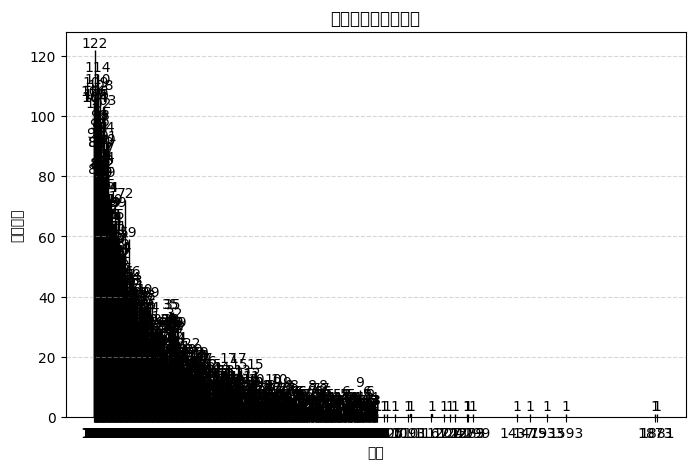

In [152]:
plt_hist(context_len)

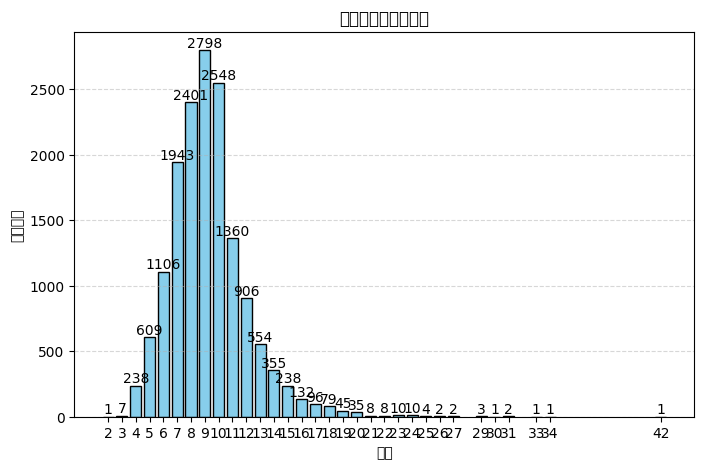

In [153]:
plt_hist(question_len)

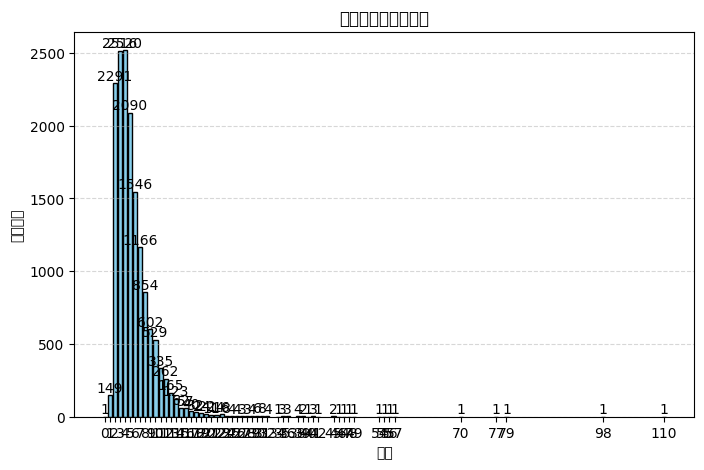

In [154]:
plt_hist(answer_len)

## 构建数据集

In [155]:
train_ratio = 0.9
max_dataset_size = 22000
train_set_size = 20000
valid_set_size = 2000

class GenQA(Dataset):
  def __init__(self, data_file):
    self.data = self.load_data(data_file)

  def load_data(self, data_file):
    Data = {}
    with open(data_file, 'rt', encoding='utf-8') as f:
      for idx, line in enumerate(f):
        if idx >= max_dataset_size:
            break
        sample = json.loads(line.strip())
        Data[idx] = sample
    return Data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

data = GenQA(train_data_address)
data_size = len(data)

train_size = int(train_ratio * data_size)
valid_size = data_size - train_size
train_data, valid_data = random_split(data, [train_size, valid_size])
test_data = GenQA(dev_data_address)

In [156]:
print(f'train set size: {len(train_data)}')
print(f'valid set size: {len(valid_data)}')
print(f'test set size: {len(test_data)}')
print(next(iter(train_data)))

train set size: 13068
valid set size: 1452
test set size: 984
{'context': '根据第六次全国人口普查数据，居住在乡村的人口占总人口的50.32%，农村居民为6.74亿人2014年末中国大陆总人口超13.6亿人。2014年底，中国农村劳动力共有40506万人，其中，外出就业15863万人，占农村劳动力总数的39.16%。其次，从事非农产业农村劳动力的为22629万人，因此，农业劳动力供给为17877万人。总数约占全国劳动力的5.3%', 'answer': '6.74亿人', 'question': '中国农民有多少', 'id': 8454}


## 数据预处理

In [157]:
from transformers import AutoTokenizer
model_checkpoint = './t5-base-chinese-cluecorpussmall'
# model_checkpoint = 'uer/t5-small-chinese-cluecorpussmall'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint,return_token_type_ids=False)

In [158]:
context = train_data[0]["context"]
question = train_data[0]["question"]
answer = train_data[0]["answer"]

inputs = tokenizer(context, question)
targets = tokenizer(answer)

In [159]:
print(tokenizer.convert_ids_to_tokens(inputs["input_ids"]))
print(tokenizer.convert_ids_to_tokens(targets["input_ids"]))

['[CLS]', '根', '据', '第', '六', '次', '全', '国', '人', '口', '普', '查', '数', '据', '，', '居', '住', '在', '乡', '村', '的', '人', '口', '占', '总', '人', '口', '的', '50', '.', '32', '%', '，', '农', '村', '居', '民', '为', '6', '.', '74', '亿', '人', '2014', '年', '末', '中', '国', '大', '陆', '总', '人', '口', '超', '13', '.', '6', '亿', '人', '。', '2014', '年', '底', '，', '中', '国', '农', '村', '劳', '动', '力', '共', '有', '405', '##06', '万', '人', '，', '其', '中', '，', '外', '出', '就', '业', '158', '##63', '万', '人', '，', '占', '农', '村', '劳', '动', '力', '总', '数', '的', '39', '.', '16', '%', '。', '其', '次', '，', '从', '事', '非', '农', '产', '业', '农', '村', '劳', '动', '力', '的', '为', '226', '##29', '万', '人', '，', '因', '此', '，', '农', '业', '劳', '动', '力', '供', '给', '为', '178', '##77', '万', '人', '。', '总', '数', '约', '占', '全', '国', '劳', '动', '力', '的', '5', '.', '3', '%', '[SEP]', '中', '国', '农', '民', '有', '多', '少', '[SEP]']
['[CLS]', '6', '.', '74', '亿', '人', '[SEP]']


In [160]:
tokenizer.sep_token

'[SEP]'

In [161]:
print(tokenizer.eos_token, tokenizer.bos_token)

None None


In [162]:
# 设置 eos_token 为 sep_token, 这个 tokenizer 默认是没有 eos_token 的
tokenizer.eos_token = tokenizer.sep_token
# 设置 bos_token 为 cls_token，这个 tokenizer 默认是没有 bos_token 的， 而 cls_token 是有的且在当前任务中没有用
tokenizer.bos_token = tokenizer.cls_token

In [163]:
print(tokenizer.eos_token, tokenizer.bos_token)

[SEP] [CLS]


In [164]:
import torch

max_input_length = 256
max_target_length = 32
sample_cnt = 4

inputs = ["问题："+ train_data[s_idx]["question"] + "?" + tokenizer.sep_token + "原文：" + train_data[s_idx]["context"] for s_idx in range(sample_cnt)]
targets = ["答案：" + train_data[s_idx]["answer"] for s_idx in range(sample_cnt)]

model_inputs = tokenizer(
    inputs,
    padding=True,
    max_length=max_input_length,
    truncation=True,
    return_tensors="pt",
    return_token_type_ids=False
)
labels = tokenizer(
    text_target=targets,
    padding=True,
    max_length=max_target_length,
    truncation=True,
    return_tensors="pt",
    return_token_type_ids=False
)["input_ids"]

# end_token_index = torch.where(labels == 102)[-1]
# for idx, end_idx in enumerate(end_token_index):
#     labels[idx][end_idx+1:] = -100

print('batch_X shape:', {k: v.shape for k, v in model_inputs.items()})
print('batch_y shape:', labels.shape)
print(model_inputs)
print(labels)

batch_X shape: {'input_ids': torch.Size([4, 256]), 'attention_mask': torch.Size([4, 256])}
batch_y shape: torch.Size([4, 10])
{'input_ids': tensor([[ 101, 7309, 7579,  ...,    0,    0,    0],
        [ 101, 7309, 7579,  ..., 2787, 1377,  102],
        [ 101, 7309, 7579,  ...,    0,    0,    0],
        [ 101, 7309, 7579,  ...,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}
tensor([[ 101, 5031, 3428, 8038,  127,  119, 8473,  783,  782,  102],
        [ 101, 5031, 3428, 8038, 6228, 7574, 3419, 2466,  102,    0],
        [ 101, 5031, 3428, 8038, 8875,  102,    0,    0,    0,    0],
        [ 101, 5031, 3428, 8038,  753,  703, 1093, 2157, 7368,  102]])


In [165]:
tokenizer.decode(model_inputs['input_ids'][0])

'[CLS] 问 题 ： 中 国 农 民 有 多 少? [SEP] 原 文 ： 根 据 第 六 次 全 国 人 口 普 查 数 据 ， 居 住 在 乡 村 的 人 口 占 总 人 口 的 50. 32 % ， 农 村 居 民 为 6. 74 亿 人 2014 年 末 中 国 大 陆 总 人 口 超 13. 6 亿 人 。 2014 年 底 ， 中 国 农 村 劳 动 力 共 有 40506 万 人 ， 其 中 ， 外 出 就 业 15863 万 人 ， 占 农 村 劳 动 力 总 数 的 39. 16 % 。 其 次 ， 从 事 非 农 产 业 农 村 劳 动 力 的 为 22629 万 人 ， 因 此 ， 农 业 劳 动 力 供 给 为 17877 万 人 。 总 数 约 占 全 国 劳 动 力 的 5. 3 % [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [166]:
tokenizer.decode(labels[0])

'[CLS] 答 案 ： 6. 74 亿 人 [SEP]'

In [167]:
# import torch
# from torch.utils.data import DataLoader
# from transformers import AutoModelForSeq2SeqLM
# import gc

# train_batch_size = 32
# test_batch_size = 64

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(f'Using {device} device')

# def clean_cuda(device):
#     if device == 'cuda':
#         # 清理无用变量
#         gc.collect()
#         torch.cuda.empty_cache()

# clean_cuda(device)
# model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
# model = model.to(device)

# def collote_fn(batch_samples):
#     batch_inputs, batch_targets = [], []
#     for sample in batch_samples:
#         input_seq = "问题："+ sample["question"] + "?" + tokenizer.sep_token + "原文：" + sample["context"]
#         output_seq = "答案："+ sample['answer']
#         batch_inputs.append(input_seq)
#         batch_targets.append(output_seq)
#     batch_data = tokenizer(
#         batch_inputs,
#         text_target=batch_targets,
#         padding=True,
#         max_length=max_input_length,
#         truncation=True,
#         return_tensors="pt",
#         return_token_type_ids=False
#     )

#     batch_data['decoder_input_ids'] = model.prepare_decoder_input_ids_from_labels(batch_data['labels'])
#     batch_data['decoder_input_ids'] = batch_data['decoder_input_ids'][:, 1:] + [tokenizer.pad_token_id] * (max_target_length - batch_data['decoder_input_ids'].shape[1])
#     end_token_index = torch.where(batch_data['labels'] == 102)[-1]
#     for idx, end_idx in enumerate(end_token_index):
#         batch_data['labels'][idx][end_idx+1:] = -100
#     return batch_data

# train_dataloader = DataLoader(train_data, batch_size=2, shuffle=False, collate_fn=collote_fn)
# valid_dataloader = DataLoader(valid_data, batch_size=2, shuffle=False, collate_fn=collote_fn)

In [168]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForSeq2SeqLM
import gc

train_batch_size = 32
test_batch_size = 64

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

def clean_cuda(device):
    if device == 'cuda':
        # 清理无用变量
        gc.collect()
        torch.cuda.empty_cache()

clean_cuda(device)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
model = model.to(device)

def collote_fn(batch_samples):
    batch_data = {
        "input_ids": [],
        "attention_mask": [],
        "decoder_input_ids": [],  # decoder 输入，包含了起始的提示 token，不包含 eos_token
        "labels": [],  # decoder 标签，用于计算损失，不包含起始的提示 token，包含了 eos_token
    }
    for sample in batch_samples:
        input_seq = "问题："+ sample["question"] + "?" + tokenizer.sep_token + "原文：" + sample["context"]
        output_seq = "答案："+ sample['answer']
        output_ids = tokenizer.encode(
            text=output_seq, truncation=True, max_length=max_target_length
        )

        decoder_input_ids = output_ids[:-1]  # 去掉 eos_token 和 tokenizer 自己加上的 [CLS]
        decoder_input_ids = decoder_input_ids + [tokenizer.pad_token_id] * (max_target_length - len(decoder_input_ids))  # 补 padding
        lables = output_ids[1:]  # 去掉起始的提示 token 和 tokenizer 自己加上的 [CLS]

        # 用 -100 用于在计算 loss 时忽略，因为该 T5 模型的实现中 loss 的 ignore_token 设置为了 -100
        # `loss_fct = CrossEntropyLoss(ignore_index=-100)`
        lables = lables + [-100] * (max_target_length - len(lables))

        # input 不需要特殊处理，直接 tokenize 即可
        inputs = tokenizer(
            text=input_seq,
            truncation=True,
            max_length=max_input_length,
            padding="max_length",
        )
        batch_data["input_ids"].append(inputs["input_ids"])
        batch_data["attention_mask"].append(inputs["attention_mask"])
        batch_data["decoder_input_ids"].append(decoder_input_ids)
        batch_data["labels"].append(lables)

    for k, v in batch_data.items():
        batch_data[k] = torch.tensor(np.array(v))
    return batch_data

train_dataloader = DataLoader(train_data, batch_size=2, shuffle=False, collate_fn=collote_fn)
valid_dataloader = DataLoader(valid_data, batch_size=2, shuffle=False, collate_fn=collote_fn)

Using cuda device


In [169]:
batch1 = next(iter(train_dataloader1))
print(batch1.keys())
print('batch shape:', {k: v.shape for k, v in batch1.items()})
print(batch1)

dict_keys(['input_ids', 'attention_mask', 'decoder_input_ids', 'labels'])
batch shape: {'input_ids': torch.Size([2, 256]), 'attention_mask': torch.Size([2, 256]), 'decoder_input_ids': torch.Size([2, 32]), 'labels': torch.Size([2, 32])}
{'input_ids': tensor([[  101,  7309,  7579,  8038,   837,  6432,   704,  6375,  2096,  2094,
          2697,  1386,  1400,  4495,  1377,  4519,  4638,  3221,  6443,   136,
           102,  1333,  3152,  8038,   712,   782,  1062,  3221,   523,  7555,
          3579,   524,  8024,   679,  3221,  2096,  2094,  8024,  1400,  4495,
          1377,  4519,  3221,  2096,  2094,  2190,  7555,  3579,  4638,  6614,
          1386,  8013,  7555,  3579,   113, 13135,  8688,   162,  9731,   114,
           117,  3217,  4904,  3198,  3309,  7826,  1744,  4638,   671,   855,
          4868,  4997,  8024,  6006,  4197,  1372,  3300,   673,  2259,  8024,
          2096,  1923,  2094,   898,  4197,  2828,   800,  2496,   868,  5439,
          2360,   671,  5663,  6435,  3

# 2. 模型训练

## 优化模型参数

In [170]:
from tqdm.auto import tqdm
import random

def train_loop(dataloader, model, optimizer, lr_scheduler, epoch, total_loss):
    progress_bar = tqdm(range(len(dataloader)))
    progress_bar.set_description(f'loss: {0:>7f}')
    finish_batch_num = (epoch-1) * len(dataloader)

    model.train()
    loss_record_step = []
    for batch, batch_data in enumerate(dataloader, start=1):
        outputs = model(input_ids=batch_data["input_ids"].to(device),
                attention_mask=batch_data["attention_mask"].to(device),
                decoder_input_ids=batch_data["decoder_input_ids"].to(device),
                labels=batch_data["labels"].to(device)
                )

        random_number = random.uniform(0, 1)

        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        loss_record_step.append(loss.item())
        progress_bar.set_description(f'loss: {total_loss/(finish_batch_num + batch):>7f}')
        progress_bar.update(1)
        del batch_data, outputs, loss
        clean_cuda(device)
    return total_loss, loss_record_step

## 评估指标

In [171]:
# ! pip install sacrebleu

In [172]:
from sacrebleu.metrics import BLEU

predictions = [
    "This plugin lets you translate web pages between several languages automatically."
]
bad_predictions_1 = ["This This This This"]
bad_predictions_2 = ["This plugin"]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]

bleu1 = BLEU(max_ngram_order=1)
print("==========BLEU-1==========")
print(bleu1.corpus_score(predictions, references).score)
print(bleu1.corpus_score(bad_predictions_1, references).score)
print(bleu1.corpus_score(bad_predictions_2, references).score)

bleu2 = BLEU(max_ngram_order=2)
print("==========BLEU-2==========")
print(bleu2.corpus_score(predictions, references).score)
print(bleu2.corpus_score(bad_predictions_1, references).score)
print(bleu2.corpus_score(bad_predictions_2, references).score)

bleu3 = BLEU(max_ngram_order=3)
print("==========BLEU-3==========")
print(bleu3.corpus_score(predictions, references).score)
print(bleu3.corpus_score(bad_predictions_1, references).score)
print(bleu3.corpus_score(bad_predictions_2, references).score)

bleu4 = BLEU(max_ngram_order=4)
print("==========BLEU-4==========")
print(bleu4.corpus_score(predictions, references).score)
print(bleu4.corpus_score(bad_predictions_1, references).score)
print(bleu4.corpus_score(bad_predictions_2, references).score)

==========BLEU-1==========
84.33740467435464
2.634980614046608
0.40867714384640685
==========BLEU-2==========
65.05696445772017
2.1514526621798953
0.40867714384640685
==========BLEU-3==========
53.804523766396294
1.8269935164445736
0.0
==========BLEU-4==========
46.750469682990186
1.683602693167689
0.0


In [173]:
import random

def test_loop(dataloader, model, sample_ovserve_ratio=0.1):
    preds, labels = [], []

    model.eval()
    for batch_data in tqdm(dataloader):
        with torch.no_grad():
            generated_tokens = model.generate(
                batch_data["input_ids"].to(device),
                attention_mask=batch_data["attention_mask"].to(device),
                max_length=max_target_length,
            ).cpu().numpy()
        label_tokens = batch_data["labels"].cpu().numpy()

        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

        random_number = random.uniform(0, 1)
        if random_number < sample_ovserve_ratio:
            print("input:", tokenizer.batch_decode(batch_data["input_ids"].cpu().numpy(), skip_special_tokens=True))
            print("output:", decoded_preds)

        label_tokens = np.where(label_tokens != -100, label_tokens, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(label_tokens, skip_special_tokens=True)

        del batch_data
        clean_cuda(device)

        preds += [pred.strip() for pred in decoded_preds]
        labels += [[label.strip()] for label in decoded_labels]
    return bleu1.corpus_score(preds, labels).score, bleu2.corpus_score(preds, labels).score, bleu3.corpus_score(preds, labels).score, bleu4.corpus_score(preds, labels).score

## 保存模型

In [174]:
test_data = GenQA(dev_data_address)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False, collate_fn=collote_fn)

test_loop(test_dataloader, model)

  0%|          | 0/16 [00:00<?, ?it/s]

input: ['问 题 ： 3 个 人 3 天 用 3 桶 水 9 个 人 9 天 用 多 少 桶 水? 原 文 ： 3 人 3 天 3 桶 水 ， 9 人 9 天 多 少 ？ 也 就 是 一 个 人 三 天 喝 一 桶 水 ， 一 个 人 九 天 喝 3 桶 ， 所 以 9 个 人 9 天 就 是 27 桶 。 | 一 个 人 三 天 用 了 一 桶 ， 九 天 用 了 三 桶 ， 一 个 人 九 天 就 用 了 三 桶 ， 九 个 人 用 了 27 桶 （ 3×9 ） | 一 个 人 一 天 用 3 分 之 1 桶 水 3 除 以 3 除 以 3 = 3 分 之 1 ， 九 个 人 九 天 用 27 桶 水 3 分 之 1 乘 9 乘 9 等 于 27 | 三 个 人 三 天 三 桶 水 ， 一 个 人 三 天 就 是 一 桶 水 ， 九 个 人 三 天 就 是 九 桶 水 ， 九 天 除 以 三 天 = 3 ， 3 & # 10008 ; 9 = 27 | 3 人 3 天 3 桶 \\ x0a1 人 1 天 1 桶 \\ x0a9 人 1 天 9 桶 \\ x0a9 人 9 天 81 桶 \\ x0', '问 题 ： 3 个 人 3 天 用 3 桶 水 9 个 人 9 天 用 多 少 桶 水? 原 文 ： 3 人 3 天 3 桶 水 ， 9 人 9 天 多 少 ？ 也 就 是 一 个 人 三 天 喝 一 桶 水 ， 一 个 人 九 天 喝 3 桶 ， 所 以 9 个 人 9 天 就 是 27 桶 。 | 一 个 人 三 天 用 了 一 桶 ， 九 天 用 了 三 桶 ， 一 个 人 九 天 就 用 了 三 桶 ， 九 个 人 用 了 27 桶 （ 3×9 ） | 一 个 人 一 天 用 3 分 之 1 桶 水 3 除 以 3 除 以 3 = 3 分 之 1 ， 九 个 人 九 天 用 27 桶 水 3 分 之 1 乘 9 乘 9 等 于 27 | 三 个 人 三 天 三 桶 水 ， 一 个 人 三 天 就 是 一 桶 水 ， 九 个 人 三 天 就 是 九 桶 水 ， 九 天 除 以 三 天 = 3 ， 3 & # 10008 ; 9 = 27 | 3 人 3 天 3 桶 \\ x0a1 人 1 天 1 桶 \\ x0a9 人 1 天 9 桶 \\ x0a9

(0.0, 0.0, 0.0, 0.0)

In [175]:
import matplotlib.pyplot as plt
import numpy as np

def save_data_and_plot(data, txt_file_path, img_file_path):
    # ===================== 写入文件部分 =====================
    # 追加写入数据（自动创建文件）
    with open(txt_file_path, 'a') as f:
        # 将数字转为字符串并换行写入
        f.write('\n'.join(map(str, data)))
        f.write('\n')  # 添加换行符分隔不同写入批次

    # ===================== 读取文件部分 =====================
    # 从文件读取所有数字
    loaded_data = []
    try:
        with open(txt_file_path, 'r') as f:
            for line in f:
                # 去除空白字符并尝试转换为浮点数
                cleaned_line = line.strip()
                if cleaned_line:
                    loaded_data.append(float(cleaned_line))
    except FileNotFoundError:
        print("错误：文件不存在")
        exit()

    # ===================== 绘图部分 =====================
    plt.figure(figsize=(10, 6))
    plt.plot(loaded_data,
            color='green',
            linestyle='--',
            marker='s',
            markersize=8,
            linewidth=2)

    # 图表装饰
    plt.title("数值变化曲线", fontsize=14, pad=20)
    plt.xlabel("数据索引", fontsize=12, labelpad=10)
    plt.ylabel("测量值", fontsize=12, labelpad=10)
    plt.grid(True, alpha=0.4, linestyle=':')

    # 自动调整坐标轴范围
    plt.xlim(0, len(loaded_data)-1)
    plt.ylim(min(loaded_data)-1, max(loaded_data)+1)

    # 保存和显示
    plt.savefig(img_file_path, dpi=300, bbox_inches='tight')
    plt.close()  # 关闭图表释放内存

    print("操作结果：")
    print(f"- 数据已保存至 {txt_file_path}")
    print(f"- 生成曲线图：{img_file_path}")
    print(f"- 加载数据量：{len(loaded_data)} 条")

In [176]:
clean_cuda(device)

In [ ]:
from transformers import AdamW, get_scheduler

learning_rate = 2e-5
epoch_num = 51

optimizer = AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=epoch_num*len(train_dataloader),
)

total_loss = 0.
best_bleu1 = 0.
best_bleu2 = 0.
best_bleu3 = 0.
best_bleu4 = 0.
best_bleu_weighted_add = 0.
txt_file_path = save_path_file + '/lossdata.txt'
img_file_path = save_path_file + '/lossdata.png'
model_parm_path = None

train_batch_size = 16
test_batch_size = 32

train_dataloader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True, collate_fn=collote_fn)
valid_dataloader = DataLoader(valid_data, batch_size=test_batch_size, shuffle=False, collate_fn=collote_fn)

if model_parm_path is not None:
    model.load_state_dict(torch.load(model_parm_path))

for t in range(epoch_num):
    clean_cuda(device)
    print(f"Epoch {t+1}/{epoch_num}\n-------------------------------")

    # 查看清理后剩余显存
    print(f"可用显存: {torch.cuda.mem_get_info()[0]/1024**3:.2f} GB")

    total_loss, loss_record_step = train_loop(train_dataloader, model, optimizer, lr_scheduler, t+1, total_loss)
    save_data_and_plot(loss_record_step, txt_file_path, img_file_path)

    # 查看清理后剩余显存
    print(f"可用显存: {torch.cuda.mem_get_info()[0]/1024**3:.2f} GB")
    valid_bleu1, valid_bleu2, valid_bleu3, valid_bleu4 = test_loop(valid_dataloader, model)
    print(f"BLEU1: {valid_bleu1:>0.2f}\n")
    if valid_bleu1 > best_bleu1:
        best_bleu1 = valid_bleu1
    print(f"BLEU2: {valid_bleu2:>0.2f}\n")
    if valid_bleu2 > best_bleu2:
        best_bleu2 = valid_bleu2
    print(f"BLEU3: {valid_bleu3:>0.2f}\n")
    if valid_bleu3 > best_bleu3:
        best_bleu3 = valid_bleu3
    print(f"BLEU4: {valid_bleu4:>0.2f}\n")
    if valid_bleu4 > best_bleu4:
        best_bleu4 = valid_bleu4

    valid_bleu = 0.1 * valid_bleu1 + 0.2 * valid_bleu2 + 0.3 * valid_bleu3 + 0.4 * valid_bleu4
    if valid_bleu > best_bleu_weighted_add or t % 5 == 0:
        best_bleu_weighted_add = valid_bleu
        print('saving new weights...\n')
        torch.save(model.state_dict(), save_path_file + f'/epoch_{t+1}_loss_{loss_record_step[-1]:0.7f}_valid_bleu_{valid_bleu:0.2f}_model_weights.bin')
print("Done!")

Epoch 1/51
-------------------------------
可用显存: 16.53 GB


  0%|          | 0/817 [00:00<?, ?it/s]

/tmp/ipykernel_1187/1171673335.py:46: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.savefig(img_file_path, dpi=300, bbox_inches='tight')
/tmp/ipykernel_1187/1171673335.py:46: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.savefig(img_file_path, dpi=300, bbox_inches='tight')
/tmp/ipykernel_1187/1171673335.py:46: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.savefig(img_file_path, dpi=300, bbox_inches='tight')
/tmp/ipykernel_1187/1171673335.py:46: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.savefig(img_file_path, dpi=300, bbox_inches='tight')
/tmp/ipykernel_1187/1171673335.py:46: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from font(s) DejaVu Sans.
  plt.savefig(img_file_path, dpi=300, bbox_inches='tight')
/tmp/ipykernel_1187/1171673335.py:46: UserWarning: Glyp

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：817 条
可用显存: 14.93 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['问 题 ： 气 垫 bb 什 么 牌 子 好? 原 文 ： 气 垫 bb 的 外 观 是 在 一 个 粉 盒 里 有 一 块 海 绵 ， 海 绵 的 空 隙 里 装 有 bb 霜 。 如 果 把 海 绵 里 的 bb 霜 挤 出 来 观 察 质 地 ， 会 发 现 气 垫 bb 霜 比 普 通 bb 霜 流 动 性 更 强 一 些 ， 质 地 更 加 轻 薄 。 气 垫 霜 裸 妆 必 备 ， 作 用 是 遮 瑕 、 调 整 肤 色 、 隐 藏 毛 孔, 产 品 设 计 便 于 携 带, 可 以 随 时 随 地 快 速 上 妆 、 补 妆 。 它 的 优 点 就 在 于 ， 上 妆 快 速 ， 妆 效 自 然 ， 光 泽 感 强 ， 一 瓶 可 以 集 美 白 、 保 湿 、 隔 离 、 防 晒 等 多 重 功 效 于 一 身 。 缺 点 是 ： 遮 瑕 度 大 多 较 一 般 ， 持 妆 时 间 不 长 。 推 荐 的 话 ， 个 人 一 直 很 喜 欢 美 宝 莲 的 产 品 ， 他 们 家 新 推 出 的 超 然 无 瑕 轻 垫 霜 ， 真 的 是 超 细 腻 的 ， 只 需 要 蘸 取 一', '问 题 ： dnf 格 斗 家 pk 转 什 么 职 业 好? 原 文 ： 后 期 刷 图 最 强 的 ， 个 人 排 名 散 打 > 气 功 > 街 霸 > 柔 道 。 主 要 投 入 资 金 ， 散 打 的 收 益 是 高 于 其 他 三 个 职 业 的 。 而 且 是 主 的 存 在 | 百 花 现 在 的 高 感 电, 只 要 配 点 没 有 问 题, 刷 图 速 度 很 快, 而 且 百 花 的 千 莲 伤 害 已 经 超 越 了 武 神 强 踢 但 是 百 花 后 期 有 些 图 会 比 较 难 受 点 儿, 比 如 中 期 的 熔 岩, 和 后 期 无 头 时 的 小 巨 人 怪 ~ 这 些 怪 火 属 性 的 ~ 现 在 国 服 的 火 属 性 怪 实 在 改 的 太... 如 果 是 吃 暗 药 开 猫 猫 拳 的 百 花, 可 以 忽 略! 武 神 刷 图 绝 对 强 悍, 虽 然 百 花 的 千 莲 可 以 赶 的 上 武 神 踢, 可 是 武 神 状 态 后 的 持 续 输 出 那 是 很 强 的, 拿 着 加 10 的 武

  0%|          | 0/817 [00:00<?, ?it/s]

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：1634 条
可用显存: 14.90 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['问 题 ： 贾 静 雯 结 婚 几 次? 原 文 ： 贾 静 雯 经 历 了 两 段 婚 姻 ， 第 一 段 婚 姻 同 样 是 嫁 入 豪 门 ， 但 是 生 了 大 女 儿 梧 桐 妹 之 后 贾 静 雯 也 是 惨 遭 家 暴 ， 实 际 上 有 时 候 在 想 ， 这 些 在 我 们 眼 中 都 是 女 神 级 别 人 ， 为 什 么 会 遇 到 家 暴 这 种 事 情 呢 ？ 也 是 不 太 懂 对 方 对 她 怎 么 大 打 出 手 的 ？ 怎 么 下 得 去 手 的 呢 ？ 看 这 梨 花 带 雨 的 样 子 也 是 实 在 不 忍 心 啊 。 但 是 贾 静 雯 还 是 没 有 选 择 忍 气 吞 声 ， 毅 然 决 然 选 择 和 对 方 离 婚 ， 只 不 过 在 离 婚 的 时 候 为 了 大 女 儿 的 抚 养 权 也 是 费 了 不 少 心 思 了 ， 不 过 幸 亏 最 后 的 结 果 是 好 的 。', '问 题 ： 梦 幻 西 游 2 几 级 要 点 卡? 原 文 ： 梦 幻 西 游 超 过 9 级 就 开 始 收 取 点 卡 了 ， 当 然 如 果 达 到 9 级 没 有 进 行 下 线 操 作 ， 然 后 继 续 升 级 ， 当 时 可 能 会 不 提 示 欠 点 的 ， 但 是 当 下 线 在 上 线 就 会 提 示 欠 点 了 。 \\ x0a \\ x0a 梦 幻 西 游 现 在 是 6 点 / 小 时 ， 梦 幻 专 用 点 数 和 通 用 点 数 都 可 以 用 于 梦 幻 西 游 点 卡 消 费 。 下 面 详 细 讲 解 下 。 \\ x0a \\ x0a 一 、 通 用 点 数 \\ x0a \\ x0a 通 用 点 数 还 可 消 费 于 网 易 公 司 提 供 的 其 他 增 值 服 务 ( 如 : 邮 箱 、 交 友 等 ) ， 但 无 法 转 为 专 用 点 数 和 寄 售 点 数 。 \\ x0a \\ x0a 获 取 途 径 ： \\ x0a \\ x0a1 、 购 买 网 易 充 值 一 卡 通 实 体 卡 或 虚 拟 卡 ， 在 网 易 充', '问 题 ： 刘 美 含 qq 号 到 底 是 多 少? 原 文 ： 刘 美 含 的 qq 是 1143413532 千 真 万 确 ， 

  0%|          | 0/817 [00:00<?, ?it/s]

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：2451 条
可用显存: 14.89 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['问 题 ： 最 适 合 程 序 员 的 字 体? 原 文 ： 其 实 代 码 最 后 都 是 纯 文 本 ， 没 有 格 式 的 。 是 等 宽 字 体 ， 每 个 字 符 一 样 宽 ， 比 较 容 易 看 出 代 码 的 对 齐 和 缩 进 。 | 其 实 编 译 器 里 的 默 认 字 体 就 是 最 好 的 ， new 也 很 不 错 ， 它 很 容 易 让 人 习 惯 ， 而 且 易 混 字 符 也 能 清 晰 辨 认 | 你 去 书 城 或 者 是 新 华 书 店 买 本 入 门 经 典 咯! 这 上 面 对 初 学 的 类 的 各 种 解 释 很 详 细, 本 且 对 关 键 字 以 及 语 法 也 解 释 的 很 精 辟. 推 荐 初 学 的 人 好 好 参 考!', '问 题 ： 2014 年 大 学 生 村 官 考 试 时 间? 原 文 ： 您 好 ， 中 公 教 育 为 您 服 务 。 您 好 ， 2014 年 大 学 生 村 官 考 试 报 名 已 于 5 月 9 号 结 束 了 ， 考 试 时 间 定 在 5 月 24 号 。 建 议 您 访 问 陕 西 中 公 教 育 网 站 ， 我 们 网 站 上 不 仅 有 海 量 的 备 考 资 料 ， 而 且 还 有 相 关 的 辅 导 课 程 ， 您 可 以 根 据 自 己 的 情 况 进 行 选 择 。 希 望 可 以 帮 到 您 。 如 有 疑 问 ， 欢 迎 向 中 公 教 育 企 业 知 道 提 问 。', '问 题 ： 迷 你 ktv 多 少 钱 一 台? 原 文 ： 到 底 迷 你 ktv 多 少 钱 一 台 呢? 只 要 几 百 元 就 可 以 成 功 购 买 到 一 个 优 唱 迷 你, 这 是 非 常 享 受 的, 如 果 你 要 开 一 个 加 盟 店 的 话, 加 盟 费 用 也 只 需 要 2 - 3 万 元, 当 然 装 修 以 及 店 面 等 费 用 是 需 要 自 己 承 担 的 。 如 果 你 想 要 加 盟 这 个 项 目 的 话, 那 就 去 官 网 了 解 一 下 加 盟 的 事 项 吧, 相 信 你 一 定 会 心 动 的 。', '问 题 ： 28 码 腰 围 是 多 少 厘 米? 原 文 ： 2 尺 1 寸 腰 围 70 厘 米 左 

  0%|          | 0/817 [00:00<?, ?it/s]

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：3268 条
可用显存: 14.88 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['问 题 ： 职 业 经 理 人 工 资 多 少? 原 文 ： 亲 ， 说 白 了 ， 所 谓 的 职 业 经 理 人 ， 其 实 就 是 企 业 的 外 聘 高 管 ， 职 业 经 理 人 薪 资 是 很 高 的 ， 一 般 都 能 在 40 万 以 上 ， 高 的 可 以 高 到 上 千 万 级 别 。 。 。 。 。 。 。 。 。 职 业 经 理 人 一 般 都 是 以 短 期 目 标 为 奋 斗 动 力 ， 企 业 请 职 业 经 理 人 就 是 为 了 实 现 短 期 目 标 的 。 。 。 。 这 口 饭 吃 着 累 ！ ！ ！', '问 题 ： 一 个 苹 果 手 机 可 以 用 几 年? 原 文 ： 如 果 正 常 使 用 的 话 ， 一 般 就 是 电 池 不 行 了 。 换 块 电 池 就 行 ， 只 要 主 板 不 坏 。 一 般 三 五 年 一 点 问 题 没 有 。 保 养 方 法 ： 新 机 入 手 前 不 要 着 急 充 电 ： 新 机 入 手 建 议 先 不 着 急 充 电 ， 正 常 使 用 电 量 到 屏 幕 提 示 10 % 需 要 充 电 。 然 后 关 机 ， 进 行 关 机 充 电 一 次 。 第 一 次 用 到 剩 余 10 % 再 完 全 充 满 电 的 时 间 大 约 为 4 小 时 。 先 插 数 据 线 ， 再 插 插 座 ： 先 把 数 据 线 插 到 苹 果 6 充 电 接 口 ， 之 后 再 把 两 孔 插 头 插 到 插 座 上 。 注 意 充 电 时 环 境 适 宜 温 度 ： 环 境 温 度 在 0 度 至 35 度 之 间 是 电 池 使 用 及 存 放 的 适 宜 温 度 ， 22 度 是 最 佳 温 度 。 注 意 苹 果 6 电 池 在 低 温 下 不 易 冲 进 去', '问 题 ： 棒 棒 堂 成 员 谁 结 婚 了? 原 文 ： 前 棒 棒 堂 成 员 吴 俊 谚 ( 鱼 ) 昨 迎 娶 圈 外 女 友 小 葵, 一 早 就 在 脸 书 高 喊 我 的 美 娇 娘! 你 的 欧 爸 来 接 你 罗! 网 友 都 被 吴 俊 谚 穿 着 西 装 笔 挺 的 模 样 吸 引, 纷 纷 献 上 祝 福 。 吴 俊 谚 前 一 天 就 在 脸 书 放 上 两 人 带 着 婚 戒

  0%|          | 0/817 [00:00<?, ?it/s]

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：4085 条
可用显存: 14.72 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['问 题 ： 贾 静 雯 结 婚 几 次? 原 文 ： 贾 静 雯 经 历 了 两 段 婚 姻 ， 第 一 段 婚 姻 同 样 是 嫁 入 豪 门 ， 但 是 生 了 大 女 儿 梧 桐 妹 之 后 贾 静 雯 也 是 惨 遭 家 暴 ， 实 际 上 有 时 候 在 想 ， 这 些 在 我 们 眼 中 都 是 女 神 级 别 人 ， 为 什 么 会 遇 到 家 暴 这 种 事 情 呢 ？ 也 是 不 太 懂 对 方 对 她 怎 么 大 打 出 手 的 ？ 怎 么 下 得 去 手 的 呢 ？ 看 这 梨 花 带 雨 的 样 子 也 是 实 在 不 忍 心 啊 。 但 是 贾 静 雯 还 是 没 有 选 择 忍 气 吞 声 ， 毅 然 决 然 选 择 和 对 方 离 婚 ， 只 不 过 在 离 婚 的 时 候 为 了 大 女 儿 的 抚 养 权 也 是 费 了 不 少 心 思 了 ， 不 过 幸 亏 最 后 的 结 果 是 好 的 。', '问 题 ： 梦 幻 西 游 2 几 级 要 点 卡? 原 文 ： 梦 幻 西 游 超 过 9 级 就 开 始 收 取 点 卡 了 ， 当 然 如 果 达 到 9 级 没 有 进 行 下 线 操 作 ， 然 后 继 续 升 级 ， 当 时 可 能 会 不 提 示 欠 点 的 ， 但 是 当 下 线 在 上 线 就 会 提 示 欠 点 了 。 \\ x0a \\ x0a 梦 幻 西 游 现 在 是 6 点 / 小 时 ， 梦 幻 专 用 点 数 和 通 用 点 数 都 可 以 用 于 梦 幻 西 游 点 卡 消 费 。 下 面 详 细 讲 解 下 。 \\ x0a \\ x0a 一 、 通 用 点 数 \\ x0a \\ x0a 通 用 点 数 还 可 消 费 于 网 易 公 司 提 供 的 其 他 增 值 服 务 ( 如 : 邮 箱 、 交 友 等 ) ， 但 无 法 转 为 专 用 点 数 和 寄 售 点 数 。 \\ x0a \\ x0a 获 取 途 径 ： \\ x0a \\ x0a1 、 购 买 网 易 充 值 一 卡 通 实 体 卡 或 虚 拟 卡 ， 在 网 易 充', '问 题 ： 刘 美 含 qq 号 到 底 是 多 少? 原 文 ： 刘 美 含 的 qq 是 1143413532 千 真 万 确 ， 

  0%|          | 0/817 [00:00<?, ?it/s]

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：4902 条
可用显存: 14.86 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['问 题 ： 天 遂 人 愿 还 是 天 随 人 愿? 原 文 ： 天 随 人 愿 解 释 ： 遂 ： 随 ， 就 。 上 天 顺 从 人 的 意 愿 。 指 事 物 的 发 展 正 合 自 己 的 心 愿 。 出 处 ： 元 · 张 国 宾 《 合 汗 衫 》 第 二 折 ： 谁 知 天 从 人 愿 ， 到 得 我 家 ， 不 上 三 日 ， 添 了 一 个 满 抱 儿 小 厮 。 示 例 ： 今 也 ， ～ ， 获 侍 巾 栉 。 但 愿 君 子 始 终 如 一 ， 则 万 幸 矣 ！ ★ 明 · 洪 《 清 平 山 堂 话 本 · 风 月 相 思 》 清 · 吴 璿 《 飞 龙 全 传 》 第 五 回 ： 喜 得 今 日 正 遇 不 将 黄 道 吉 期 ， 正 是 天 遂 人 愿 ， 夙 世 奇 缘 也 。 近 义 词 ： 天 从 人 愿 、 天 随 人 愿 反 义 词 ： 天 不 作 美 歇 后 语 ： 想 吃 空 心 菜 来 个 卖 藕 的 用 法 ： 作 宾 语 、 分 句 、 定 语 ； 指 特 别 顺 心 。', '问 题 ： 2016 年 中 国 网 民 数 量? 原 文 ： 中 国 互 联 网 络 信 息 中 心 最 新 发 布 的 统 计 数 据 显 示, 截 至 2016 年 6 月, 中 国 网 民 总 数 已 达 7. 10 亿, 19 岁 以 下 网 民 占 全 体 网 民 的 23 %, 其 中 年 龄 低 于 10 岁 的 网 民 超 过 2059 万 。 与 2015 年 底 的 数 据 相 比, 10 岁 以 下 儿 童 群 体 占 比 有 所 增 长, 互 联 网 在 低 年 龄 段 继 续 渗 透 。', '问 题 ： 肯 德 基 宅 急 送 多 少 起 送? 原 文 ： 不 设 最 低 消 费 ， 外 送 费 要 付 4 元 ， 有 很 多 家 宅 急 送 ， 只 要 不 偏 僻 因 该 都 送 的 到 的 。 肯 德 基 是 美 国 跨 国 连 锁 餐 厅 之 一 ， 同 时 也 是 世 界 第 二 大 速 食 及 最 大 炸 鸡 连 锁 企 业 ， 由 哈 兰 德 · 大 卫 · 桑 德 斯 于 1930 年 在 肯 塔 基 州 路 易 斯 维 尔 创 建 ， 主 要 出 售 炸 鸡 、 汉 堡 、 薯

  0%|          | 0/817 [00:00<?, ?it/s]

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：5719 条
可用显存: 14.66 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['问 题 ： 气 垫 bb 什 么 牌 子 好? 原 文 ： 气 垫 bb 的 外 观 是 在 一 个 粉 盒 里 有 一 块 海 绵 ， 海 绵 的 空 隙 里 装 有 bb 霜 。 如 果 把 海 绵 里 的 bb 霜 挤 出 来 观 察 质 地 ， 会 发 现 气 垫 bb 霜 比 普 通 bb 霜 流 动 性 更 强 一 些 ， 质 地 更 加 轻 薄 。 气 垫 霜 裸 妆 必 备 ， 作 用 是 遮 瑕 、 调 整 肤 色 、 隐 藏 毛 孔, 产 品 设 计 便 于 携 带, 可 以 随 时 随 地 快 速 上 妆 、 补 妆 。 它 的 优 点 就 在 于 ， 上 妆 快 速 ， 妆 效 自 然 ， 光 泽 感 强 ， 一 瓶 可 以 集 美 白 、 保 湿 、 隔 离 、 防 晒 等 多 重 功 效 于 一 身 。 缺 点 是 ： 遮 瑕 度 大 多 较 一 般 ， 持 妆 时 间 不 长 。 推 荐 的 话 ， 个 人 一 直 很 喜 欢 美 宝 莲 的 产 品 ， 他 们 家 新 推 出 的 超 然 无 瑕 轻 垫 霜 ， 真 的 是 超 细 腻 的 ， 只 需 要 蘸 取 一', '问 题 ： dnf 格 斗 家 pk 转 什 么 职 业 好? 原 文 ： 后 期 刷 图 最 强 的 ， 个 人 排 名 散 打 > 气 功 > 街 霸 > 柔 道 。 主 要 投 入 资 金 ， 散 打 的 收 益 是 高 于 其 他 三 个 职 业 的 。 而 且 是 主 的 存 在 | 百 花 现 在 的 高 感 电, 只 要 配 点 没 有 问 题, 刷 图 速 度 很 快, 而 且 百 花 的 千 莲 伤 害 已 经 超 越 了 武 神 强 踢 但 是 百 花 后 期 有 些 图 会 比 较 难 受 点 儿, 比 如 中 期 的 熔 岩, 和 后 期 无 头 时 的 小 巨 人 怪 ~ 这 些 怪 火 属 性 的 ~ 现 在 国 服 的 火 属 性 怪 实 在 改 的 太... 如 果 是 吃 暗 药 开 猫 猫 拳 的 百 花, 可 以 忽 略! 武 神 刷 图 绝 对 强 悍, 虽 然 百 花 的 千 莲 可 以 赶 的 上 武 神 踢, 可 是 武 神 状 态 后 的 持 续 输 出 那 是 很 强 的, 拿 着 加 10 的 武

  0%|          | 0/817 [00:00<?, ?it/s]

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：6536 条
可用显存: 14.71 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['问 题 ： 2016 年 银 行 存 款 利 率? 原 文 ： 2016 年 工 商 银 行 一 年 定 期 存 款 的 年 利 率 是 ; 1. 95 %, 如 果 存 入 10000 元 到 期 可 得 利 息 是 ; 10000 * 1 * 1. 95 % = 195 元 。 | 银 行 存 款 利 率 的 话, 总 的 来 说 是 由 央 行 所 规 定 的, 今 年 的 存 款 利 率 三 个 月 的 1. 35, 六 个 月 的 1. 55, 年 利 率 1. 75, 都 不 是 很 高 的 说, 想 要 通 过 这 个 来 存 钱 的 话 很 难 啊, 还 不 如 像 那 些 理 财 产 品 呢, 收 益 还 要 高 一 些, 而 且 也 很 方 便, 像 理 财 通 上 的 货 币 基 金, 保 险 理 财 都 是 这 样 的, 利 率 还 比 较 高, 他 是 互 联 网 的 一 种 新 型 的 产 品, 比 较 快 捷', '问 题 ： 熬 夜 的 人 喝 什 么 汤? 原 文 ： 可 以 吃 党 参 炖 鸡 汤 。 用 料 ： 鸡 一 只 ， 干 香 菇 5 朵 、 红 枣 6 个 、 枸 杞 5g 、 党 参 一 支 、 百 合 5g 、 生 姜 一 大 块 拍 散 。 做 法 ： 1. 烧 一 大 锅 水 ， 煮 至 沸 腾 ， 下 入 鸡 ， 煮 约 3 - 4 分 钟 的 时 间 ， 不 要 煮 过 久 。 2. 将 鸡 捞 出 ， 水 倒 掉 。 3. 高 压 锅 中 加 入 清 水 ， 将 泡 发 好 的 党 参 ， 香 菇 等 作 料 倒 入 锅 中 ， 为 了 让 鸡 肉 更 酥 烂 ， 可 加 入 少 量 的 植 物 油 。 4. 盖 上 高 压 锅 盖 ， 大 火 烧 至 高 压 锅 开 始 出 汽 ， 然 后 改 小 火 ， 炖 30 分 钟 。 5. 改 盛 入 汤 煲 内 ， 加 入 鸡 精 ， 胡 椒 粉 ， 再 次 烧 开 ， 这 样 上 桌 就 不 会 很 快 就 冷 掉 了 。 6. 撒 上 葱 花 就 可 以 上 桌 了 。', '问 题 ： 硬 盘 开 盘 恢 复 多 少 钱? 原 文 ： 参 考 ： 硬 盘 不 开 盘 恢 复 的 话 ， 问 题 比 较 简 单 的 ， 自 己 可 以 

  0%|          | 0/817 [00:00<?, ?it/s]

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：7353 条
可用显存: 14.88 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['问 题 ： 泰 国 落 地 签 费 用? 原 文 ： 1 、 填 写 一 张 申 请 表 ， 并 签 字 ； 2 、 一 张 白 底 2 寸 照 片 （ 厘 米 ） ； 3 、 出 示 返 程 机 票 ； 有 15 天 内 离 境 的 机 票 ； （ 一 定 要 有 confirmation 字 样 ） 4 、 半 年 以 上 有 效 期 本 人 护 照 ， 护 照 复 印 件 一 份 办 理 时 间 ： 大 约 10 - 15 分 钟 费 用 ： 1000 泰 铢 （ 普 通 ） ， 只 接 受 泰 铢 。 签 证 区 间 ： 15 天 注 意 ： 申 请 落 地 签 证 时 ， 旅 客 须 持 有 在 泰 期 间 足 够 之 生 活 费 用 ， 折 合 泰 币 至 少 每 人 10000 泰 铢 ， 或 者 每 个 家 庭 20000 泰 铢 。', '问 题 ： 什 么 牌 子 雨 披 好? 原 文 ： 主 要 看 你 想 做 的 价 位 了 。 便 宜 一 点 的 是 用 ， 涤 塔 夫 做 涂 层 做 的 ， 防 水 效 果 根 据 涂 层 的 水 压 来 定 ， 水 压 越 高 ， 价 格 越 贵 ， 正 常 是 水 压 。 中 档 的 可 以 用 尼 丝 纺 来 做 ， 的 ， 也 是 做 涂 层 ， 手 感 较 涤 纶 的 要 好 。 我 们 做 的 高 档 的 都 是 高 密 以 上 的 尼 龙 做 透 气 透 湿 涂 层 的 ， 做 出 来 的 雨 衣 可 以 折 叠 放 口 袋 的 ， 手 感 非 常 好 。 可 以 lianluo 我 ， 一 五 一 五 一 七 一 九 五 七 三 | 好 的 雨 衣 ， 选 择 环 球 雨 衣 厂 的 质 量 好 卖 的 好 ， 出 售 快 ~ ~ 很 多 高 档 多 年 不 脱 胶 的 摩 托 车 雨 披 口 碑 很 好 的 ~', '问 题 ： 战 舰 世 界 炮 弹 视 角 是 那 个 键? 原 文 ： 战 舰 世 界 按 键 设 置 如 下 ： 1 、 键 同 时 鼠 标 右 键 也 具 有 这 种 功 能 ， 唯 一 不 同 的 是 有 时 再 次 点 击 鼠 标 右 键 无 法 解 除 锁 定 ， 这 时 只 要 按 下 键 就 可 。 一 般 情 况 下 ， 远 距 离 开 

  0%|          | 0/817 [00:00<?, ?it/s]

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：8170 条
可用显存: 14.69 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['问 题 ： 职 业 经 理 人 工 资 多 少? 原 文 ： 亲 ， 说 白 了 ， 所 谓 的 职 业 经 理 人 ， 其 实 就 是 企 业 的 外 聘 高 管 ， 职 业 经 理 人 薪 资 是 很 高 的 ， 一 般 都 能 在 40 万 以 上 ， 高 的 可 以 高 到 上 千 万 级 别 。 。 。 。 。 。 。 。 。 职 业 经 理 人 一 般 都 是 以 短 期 目 标 为 奋 斗 动 力 ， 企 业 请 职 业 经 理 人 就 是 为 了 实 现 短 期 目 标 的 。 。 。 。 这 口 饭 吃 着 累 ！ ！ ！', '问 题 ： 一 个 苹 果 手 机 可 以 用 几 年? 原 文 ： 如 果 正 常 使 用 的 话 ， 一 般 就 是 电 池 不 行 了 。 换 块 电 池 就 行 ， 只 要 主 板 不 坏 。 一 般 三 五 年 一 点 问 题 没 有 。 保 养 方 法 ： 新 机 入 手 前 不 要 着 急 充 电 ： 新 机 入 手 建 议 先 不 着 急 充 电 ， 正 常 使 用 电 量 到 屏 幕 提 示 10 % 需 要 充 电 。 然 后 关 机 ， 进 行 关 机 充 电 一 次 。 第 一 次 用 到 剩 余 10 % 再 完 全 充 满 电 的 时 间 大 约 为 4 小 时 。 先 插 数 据 线 ， 再 插 插 座 ： 先 把 数 据 线 插 到 苹 果 6 充 电 接 口 ， 之 后 再 把 两 孔 插 头 插 到 插 座 上 。 注 意 充 电 时 环 境 适 宜 温 度 ： 环 境 温 度 在 0 度 至 35 度 之 间 是 电 池 使 用 及 存 放 的 适 宜 温 度 ， 22 度 是 最 佳 温 度 。 注 意 苹 果 6 电 池 在 低 温 下 不 易 冲 进 去', '问 题 ： 棒 棒 堂 成 员 谁 结 婚 了? 原 文 ： 前 棒 棒 堂 成 员 吴 俊 谚 ( 鱼 ) 昨 迎 娶 圈 外 女 友 小 葵, 一 早 就 在 脸 书 高 喊 我 的 美 娇 娘! 你 的 欧 爸 来 接 你 罗! 网 友 都 被 吴 俊 谚 穿 着 西 装 笔 挺 的 模 样 吸 引, 纷 纷 献 上 祝 福 。 吴 俊 谚 前 一 天 就 在 脸 书 放 上 两 人 带 着 婚 戒

  0%|          | 0/817 [00:00<?, ?it/s]

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：8987 条
可用显存: 14.68 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['问 题 ： psd 文 件 用 什 么 打 开? 原 文 ： 如 果 仅 仅 只 是 阅 览 而 不 是 编 辑 文 件 ， 2345 看 图 王 就 可 以 了 ， 整 个 安 装 包 只 有 ， 完 全 没 有 必 要 去 下 载 软 件 ！ 2345 看 图 王 官 方 下 载 ： http : / / www. googlechromer. cn / soft2016042001 - 2345kantuwang. html', '问 题 ： 北 京 哪 个 印 刷 厂 比 较 好? 原 文 ： 北 京 最 好 的 印 刷 厂 应 该 是 各 个 方 面 都 是 第 一 的, 印 刷 厂 在 北 京 一 共 大 约 有 上 百 家 。 北 京 最 好 的 印 刷 厂 其 实 比 较 难 评 比, 因 为 北 京 最 好 的 印 刷 厂 就 几 家, 其 中 印 刷 厂 里 质 量 最 有 保 障 的 就 是 : 北 京 市 中 奥 印 刷 包 装 厂, 这 家 是 北 京 最 好 的 印 刷 厂 之 一, 并 且 是 价 格 比 较 实 惠, 综 合 来 说 是 北 京 质 量 和 价 格 兼 得 的 印 刷 厂 了! 希 望 你 能 在 这 北 京 最 好 的 印 刷 厂 里 印 到 你 最 满 意 的 东 东 咯 。', '问 题 ： 200 左 右 的 入 耳 耳 机? 原 文 ： 这 个 的 话 主 要 还 是 看 您 的 听 音 取 向 以 及 选 择 头 戴 式 还 是 入 耳 式 的 吧 ， 如 果 是 入 耳 式 的 话 您 可 以 看 一 下 得 胜 - 2280 耳 机 ， 这 款 耳 机 我 前 段 时 间 刚 入 手 了 一 款 ， 感 觉 在 音 质 方 面 的 话 可 能 是 驱 动 单 元 采 用 纯 金 属 振 膜 的 缘 故 ， 听 起 来 的 音 质 效 果 还 蛮 细 腻 有 层 次 感 的 ， 具 体 的 话 您 到 网 上 去 了 解 一 下 ， 以 上 的 回 答 希 望 能 帮 到 你 ！', '问 题 ： 2011 年 比 特 币 价 格? 原 文 ： 2011 年 的 时 候 比 特 币 的 价 格 是 非 常 低 的, 低 的 可 怜 。 最 高 时 不 到 40 美 元 。 在 2010 

  0%|          | 0/817 [00:00<?, ?it/s]

操作结果：
- 数据已保存至 ./lossdata.txt
- 生成曲线图：./lossdata.png
- 加载数据量：9804 条
可用显存: 14.87 GB


  0%|          | 0/46 [00:00<?, ?it/s]

input: ['问 题 ： psd 文 件 用 什 么 打 开? 原 文 ： 如 果 仅 仅 只 是 阅 览 而 不 是 编 辑 文 件 ， 2345 看 图 王 就 可 以 了 ， 整 个 安 装 包 只 有 ， 完 全 没 有 必 要 去 下 载 软 件 ！ 2345 看 图 王 官 方 下 载 ： http : / / www. googlechromer. cn / soft2016042001 - 2345kantuwang. html', '问 题 ： 北 京 哪 个 印 刷 厂 比 较 好? 原 文 ： 北 京 最 好 的 印 刷 厂 应 该 是 各 个 方 面 都 是 第 一 的, 印 刷 厂 在 北 京 一 共 大 约 有 上 百 家 。 北 京 最 好 的 印 刷 厂 其 实 比 较 难 评 比, 因 为 北 京 最 好 的 印 刷 厂 就 几 家, 其 中 印 刷 厂 里 质 量 最 有 保 障 的 就 是 : 北 京 市 中 奥 印 刷 包 装 厂, 这 家 是 北 京 最 好 的 印 刷 厂 之 一, 并 且 是 价 格 比 较 实 惠, 综 合 来 说 是 北 京 质 量 和 价 格 兼 得 的 印 刷 厂 了! 希 望 你 能 在 这 北 京 最 好 的 印 刷 厂 里 印 到 你 最 满 意 的 东 东 咯 。', '问 题 ： 200 左 右 的 入 耳 耳 机? 原 文 ： 这 个 的 话 主 要 还 是 看 您 的 听 音 取 向 以 及 选 择 头 戴 式 还 是 入 耳 式 的 吧 ， 如 果 是 入 耳 式 的 话 您 可 以 看 一 下 得 胜 - 2280 耳 机 ， 这 款 耳 机 我 前 段 时 间 刚 入 手 了 一 款 ， 感 觉 在 音 质 方 面 的 话 可 能 是 驱 动 单 元 采 用 纯 金 属 振 膜 的 缘 故 ， 听 起 来 的 音 质 效 果 还 蛮 细 腻 有 层 次 感 的 ， 具 体 的 话 您 到 网 上 去 了 解 一 下 ， 以 上 的 回 答 希 望 能 帮 到 你 ！', '问 题 ： 2011 年 比 特 币 价 格? 原 文 ： 2011 年 的 时 候 比 特 币 的 价 格 是 非 常 低 的, 低 的 可 怜 。 最 高 时 不 到 40 美 元 。 在 2010 

  0%|          | 0/817 [00:00<?, ?it/s]

In [ ]:
test_data = GenQA(dev_data_address)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False, collate_fn=collote_fn)

import json

# model.load_state_dict(torch.load('./epoch_16_loss_4.4422817_valid_bleu_0.00_model_weights.bin'))

model.eval()
with torch.no_grad():
    print('evaluating on test set...')
    sources, preds, labels = [], [], []
    for batch_data in tqdm(test_dataloader):
        with torch.no_grad():
            generated_tokens = model.generate(
                batch_data["input_ids"].to(device),
                attention_mask=batch_data["attention_mask"].to(device),
                max_length=max_target_length,
            ).cpu().numpy()

        label_tokens = batch_data["labels"].cpu().numpy()

        decoded_sources = tokenizer.batch_decode(
            batch_data["input_ids"].cpu().numpy(),
            skip_special_tokens=True,
            use_source_tokenizer=True
        )
        # print('decoded_sources', decoded_sources)

        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        # print('decoded_preds', decoded_preds)
        label_tokens = np.where(label_tokens != -100, label_tokens, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(label_tokens, skip_special_tokens=True)
        # print('decoded_labels', decoded_labels)

        sources += [source.strip() for source in decoded_sources]
        preds += [pred.strip() for pred in decoded_preds]
        labels += [[label.strip()] for label in decoded_labels]
    bleu_score = bleu4.corpus_score(preds, labels).score
    print(f"Test BLEU: {bleu_score:>0.2f}\n")
    results = []
    print('saving predicted results...')
    for source, pred, label in zip(sources, preds, labels):
        results.append({
            "sentence": source,
            "prediction": pred,
            "translation": label[0]
        })
    with open('test_data_pred.json', 'wt', encoding='utf-8') as f:
        for exapmle_result in results:
            f.write(json.dumps(exapmle_result, ensure_ascii=False) + '\n')

In [ ]:
# model.load_state_dict(torch.load('./epoch_16_loss_4.4422817_valid_bleu_0.00_model_weights.bin'))
test_dataloader1 = DataLoader(test_data, batch_size=1, shuffle=False, collate_fn=collote_fn)
test_loop(test_dataloader1, model, sample_ovserve_ratio=1)


  0%|          | 0/984 [00:00<?, ?it/s]

input: ['问 题 ： 2017 年 银 行 贷 款 基 准 利 率? 原 文 ： 年 基 准 利 率 4. 35 % 。 从 实 际 看, 贷 款 的 基 本 条 件 是 : 一 是 中 国 大 陆 居 民, 年 龄 在 60 岁 以 下 ; 二 是 有 稳 定 的 住 址 和 工 作 或 经 营 地 点 ; 三 是 有 稳 定 的 收 入 来 源 ; 四 是 无 不 良 信 用 记 录, 贷 款 用 途 不 能 作 为 炒 股, 赌 博 等 行 为 ; 五 是 具 有 完 全 民 事 行 为 能 力 。']
output: ['答 案 ： 4. 35 %']
input: ['问 题 ： 2017 年 银 行 贷 款 基 准 利 率? 原 文 ： 年 基 准 利 率 4. 35 % 。 从 实 际 看, 贷 款 的 基 本 条 件 是 : 一 是 中 国 大 陆 居 民, 年 龄 在 60 岁 以 下 ; 二 是 有 稳 定 的 住 址 和 工 作 或 经 营 地 点 ; 三 是 有 稳 定 的 收 入 来 源 ; 四 是 无 不 良 信 用 记 录, 贷 款 用 途 不 能 作 为 炒 股, 赌 博 等 行 为 ; 五 是 具 有 完 全 民 事 行 为 能 力 。']
output: ['答 案 ： 4. 35 %']
input: ['问 题 ： 格 力 空 调 哪 个 系 列 好? 原 文 ： 系 列 是 最 好 的 ， 采 用 国 际 顶 尖 技 术 （ 由 格 力 自 主 研 发 ） 双 级 变 频 压 缩 机 ， 提 高 压 缩 机 运 转 效 率 ， 制 冷 制 热 能 力 更 强 劲 ； 1 赫 兹 变 频 技 术 ， 使 空 调 相 当 于 一 个 15 电 灯 泡 ， 更 加 节 能 省 电 ； 送 风 面 积 广 ， 风 力 大 ； 生 态 风 ， 净 化 空 气 。 非 常 不 错 ， 现 在 国 美 在 做 活 动 ， 可 以 了 解 一 下 。']
output: ['答 案 ：']
input: ['问 题 ： 橱 柜 宽 度? 原 文 ： 平 面 操 作 区 域 进 深 （ 即 宽 度 ） 以 40 至 60 厘 米 为 宜 ； 要 充 分 考 虑 洗 菜 盆 的 宽 度 。 以 标 准 洗 菜 盆 来 算 ， 应 选 择

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fb908654410>>
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


input: ['问 题 ： 小 米 max2017 开 售 时 间? 原 文 ： 小 米 和 小 米 2 系 列 是 小 米 手 机 两 个 大 屏 幕 手 机 系 列, 大 屏 手 机 很 是 受 到 一 些 网 友 的 喜 欢, 小 米 是 小 米 之 前 上 线 的 手 机, 但 现 在 已 经 下 架 了, 但 是 不 要 着 急, 小 米 即 将 发 布 了, 小 米 什 么 时 候 发 布? 米 粉 们 有 没 有 很 期 待, 赶 紧 一 起 看 看 吧 。 | 现 在 消 息 称 小 米 手 机 即 将 登 场, 根 据 爆 料, 这 款 手 机 会 在 本 月 也 就 是 5 月 23 日 正 式 发 布, 而 且 新 手 机 的 宣 传 工 作 很 快 就 会 开 启 。 | 硬 件 方 面, 这 款 手 机 会 采 用 6. 4 英 寸 屏 幕, 依 然 是 分 辨 率, 电 池 容 量 提 升 到 了 。 有 两 个 版 本 分 别 是 骁 龙 626 处 理 器 + 存 储 版 本, 以 及 骁 龙 660 + 存 储 版']
output: ['答 案 ： 5 月 23 日 个 月 个 月 个 月 个 月 个 月 个 月 个 月 个 月']
input: ['问 题 ： 北 京 园 博 园 门 票 价 格? 原 文 ： 一 、 票 价 北 京 园 博 园 票 价 为 每 人 次 20 元 ( 试 行 ), 军 人 、 残 疾 人 、 老 人 、 儿 童 、 学 生 等 票 价 按 照 行 业 规 定 减 半 或 者 减 免 。 二 、 具 体 优 惠 政 策 1. 身 高 1. 2 米 以 下 儿 童 免 票 ; 6 - 18 周 岁 ( 含 18 周 岁 ) 未 成 年 人, 门 票 半 价 优 惠 。 2. 残 疾 人 、 离 休 人 员 、 退 休 军 人 、 现 役 军 人 、 武 警 官 兵 、 烈 士 家 属 、 见 义 勇 为 人 员 、 省 、 部 级 以 上 劳 模 凭 有 效 证 件 免 票 。 3. 大 、 中 、 小 学 学 生 ( 不 含 成 人 教 育 学 生 ) 、 外 国 留 学 生 凭 学 生 证, 门 票 半 价 优 惠 。 4. 60 - 64 周 岁 老 年 人 凭 有 效 证 件, 门 票 半 